# The Parks-McClellan Filter Design Method

The Parks-McClellan (PM) algorithm is a clever application of advanced polynomial fitting techniques to the problem of FIR filter design. In this notebook we will explore the key ideas behind the method by considering the design of a simple Type-I lowpass filter.

In [1]:
# standard bookkeeping
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from ipywidgets import interactive, fixed
plt.rcParams["figure.figsize"] = (14,4)

The first intuition is to recognize that finding the filter's coefficients is equivalent to solving a polynomial fitting problem. Since we want a linear-phase filter, the filter will be symmetric and we can easily show that its frequency response is the real-valued function:

$$
    H(e^{j\omega}) = h[0] + \sum_{n = 1}^{M} 2h[n]\cos n\omega
$$

In the above expression, the $N = 2M+1$ nonzero taps of the impulse response $h[n]$ are $h[-M]$ to $h[M]$. Given a (positive) passband $[0, \omega_p]$ and a stopband $[\omega_s, \pi]$, we need to fit $H(e^{j\omega})$ to one in the passband and zero in the stopband as in the following figure. 

<img src="specs.png" alt="Drawing" style="width: 600px;"/>

The key idea here is to realize that, by using Chebishev polynomials, we can write

$$
   H(e^{j\omega}) =  \sum_{n = 0}^{M}p_n x^n \qquad \mbox{with $x = \cos\omega$}
$$

While the relation between the $M+1$ $p_n$ coefficients and the $2M+1$ filter coefficients is nonlinear, it is easily invertible and therefore we can just concentrate on fitting the degree-$M$ polynomial over the desired response.

For the sake of simplicity, let's skip some of the details associated to the Chebishev substitution and let's examine the following equivalent problem:

> consider the desired function: $$ D(x) = \begin{cases} 1 & \mbox{for $x\in [0, A]$} \\ 0 & \mbox{for $x\in [B,1]$} \end{cases}$$ <br> find the coefficients of a degree-$M$ polynomial $P(x)$ so that $P(x)\approx D(x)$ over $[0,A]\cup [B,1]$

## Standard polynomial fitting

The simplest approach is to use standard polynomial fitting: choose $a$ points in $[0, A]$ and $b$ points in $[B, 1]$ so that $a+b = M+1$ and find an interpolator over the coordinate pairs:

$$
  (x_0, 1), (x_1, 1), \ldots, (x_{a-1}, 1), (x_a, 0), (x_{a+1}, 0), \ldots, (x_{a+b-1}, 0)
$$

The result will minimize the mean square error between the interpolator and the piecewise characteristic we are trying to approximate. 

We can write a simple Python function to test this approach; you can play with the sliders below and see the result of the plain interpolation as the order and the size of the intervals change:

In [49]:
def MSE_fit(A, B, order):
    if order < 3:
        raise ValueError("order is too small, we need at least 3")
    
    # interpolation points always one more than the order of the interpolator
    pts = order+1
    # split number of interpolation points across intervals proportionately 
    #  with the length of each interval 
    ptsA = int(pts * A / (A+(1-B)))
    if ptsA < 2:
        ptsA = 2
    ptsB = pts - ptsA
    
    # for the MSE fit, place a point at each interval edge and distribute the rest
    #  (if any) evenly over the interval
    x = np.concatenate((
        np.arange(0, ptsA) * (A / (ptsA-1)),
        B + np.arange(0, ptsB) * ((1-B) / (ptsB-1))            
        ))
    y = np.concatenate((
        np.ones(ptsA),
        np.zeros(ptsB)            
        ))
    
    # now just solve the linear interpolation problem
    p = np.poly1d(np.polyfit(x, y, order))
    return p, x, y

In [50]:
def MSE_fit_show(A=0.4, B=0.6, order=10):
    p, x, y = MSE_fit(A, B, order)
    
    t = np.linspace(0, 1, 100)
    lims = [(0,1,-.5,1.5), (0,A,0.8,1.2), (B,1,-0.2,0.2)]
    for n, r in enumerate(lims):
        plt.subplot(1,3,n+1)
        plt.plot((0,A), (1,1), 'red', 
                 (B,1), (0,0), 'red',  
                 x, y, 'oy', 
                 t, p(t), '-')
        plt.xlim(r[0], r[1])
        plt.ylim(r[2], r[3]) 

C:\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


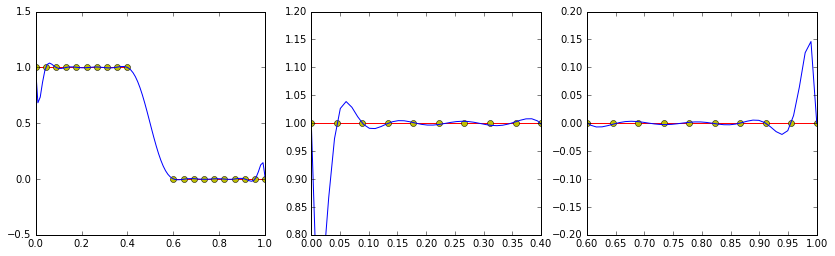

In [51]:
v = interactive(MSE_fit_show, order=(3,30), A=(0.0, 0.5), B=(0.5, 1.0))
display(v)

As you can see, simple polynomial interpolation, while minimizing the MSE has two problems:

 * it becomes numerically unstable as soon as the order of the interpolation exceeds 16 or 17
 * although the MSE is minimized, the **maximum** error can become very large
 
Because of these problems, direct interpolation is rarely used in numerical analysis and filter design is no exception. 

## Minimax fitting

As we said, the first clever intuition behind the the Parks-McClellan algorithm is rephrasing the filter design problem as a polynomial interpolation. The real stroke of genius, however, is the use of a different kind of polynomial fitting called *minimax* approximation. In this kind of fitting the goal is to minimixe the *maximum* error between the polynomial and the desired function over the intervals of interest:

$$
    E = \min\max_{[0,A]\cup [B,1]} | P(x) - D(x) |
$$

This is brilliant for two reasons: 

* the minimax criterion gives us a guarantee on the worst-case error for the filter response
* an obscure yet powerful theorem, called the **alternation theorem**, gives us a remarkably straightforward recipe to build a robust numerical algorithm that finds the solution.

### The Alternation Theorem

Because of the fundamental theorem of algebra, a non-constant polynomial cannot be constant over an interval. Since our polynomial cannot be a constant (it needs to move from 1 in the passband to zero in the stopband), it will necessarily oscillate over the approximation intervals. As you could see from the previous demo, MSE minimization tries to keep the oscillations small over the approximation intervals, but the price to pay is potentially wide oscillations at the band edges. The minimax approximation will allow for a wider set of oscillations in order to eliminate the wider swings. In either case, since the polynomial oscillates around the target value, the error will oscillate between positive and negative peaks. The alternation theorem states that 

> $P(x)$ is the minimax approximation to $D(x)$ if and only if $P(x) - D(x)$ alternates $M+2$ times between $+E$ and $-E$ over $[0,A]\cup [B,1]$

The alternation theorem gives one thing right away: the ability to recognize if a polynomial is the minimax solution. All we need to do is look at the extrema of the error and check that 

* they are $M+2$
* they alternate in sign
* their magnitude is exactly the same

We can write a simple Python function to find the extrema of the error:

In [52]:
def find_error_extrema(p, A, B):
    intervals = {
        (0, A): 1, 
        (B, 1): 0
    }
    loc = [] # locations of the extrema
    err = [] # values of the extrema
    for rng, val in intervals.iteritems():
        # we don't need enormous precision, 100 points per interval will do
        t = np.linspace(rng[0], rng[1], 100)
        y = val - p(t) # error values
        # this finds all the points where the error changes sign:
        ix = np.diff(np.sign(np.diff(y))).nonzero()[0] + 1 # local min+max
        loc = np.hstack((loc, t[0], t[ix], t[-1]))
        err = np.hstack((err, y[0], y[ix], y[-1]))
    return loc, err

With this, it's easy to verify that the MSE fit does not satisfy the alternation theorem: the magnitude of the peaks is not constant.

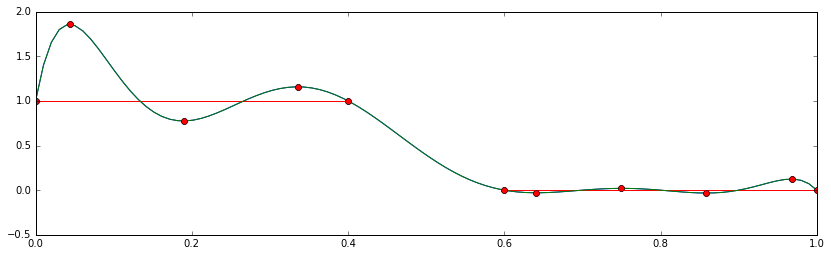

In [54]:
A = 0.4
B = 0.6
p, x, y = MSE_fit(A, B, 8)

loc, err = find_error_extrema(p, 0.4, 0.6)

t = np.linspace(0, 1, 100)
plt.plot(loc, p(loc), 'or', t, p(t), '-')
plt.plot((0,A), (1,1), 'red', 
         (B,1), (0,0), 'red',  
         t, p(t), '-',
         loc, p(loc), 'or');

### The Remez Exchange Algorithm

The alternation theorem provides us also with a very efficient way to find the coefficients of $P(x)$. Suppose we knew the exact ordinates $x_i$ of the $M+2$ alternations; in this case we could solve the following system of linear equations

$$
    \left\{\begin{array}{lcl}
        p_0 + p_1 x_0 + p_2 x_0^2 + \ldots + p_Mx_0^M + (-1)^0E &=& D(x_0) \\ 
        p_0 + p_1 x_1 + p_2 x_1^2 + \ldots + p_Mx_1^M + (-1)^1E &=& D(x_1) \\ 
        \ldots \\ 
        p_0 + p_1 x_{M+1} + p_2 x_{M+1}^2 + \ldots + p_Mx_{M+1}^M + (-1)^{M+1}E &=& D(x_0) 
      \end{array}\right.
$$

and find in one go both the $M+1$ polynomial coefficients *and* the value of the minimax error $E$. Of course we don't know the $x_i$ in advance but we can start with a guess, and solve the system anyway. Once we find the polynomial coefficients, we use Remez's exchange algorithm:

* find the locations for the maxima and minima of the error for the $P(x)$ we just found
* if the extrema satisfy the alternation theorem, we are done
* otherwise, use the new locations as a new guess, solve the system again and repeat.



The Remez algorithm is remarkably fast and robust. Here is an implementation you can play with. First, we need an auxiliary function to solve the system of equations above; we will use standard linear algebra functions.

In [55]:
def solve(x, y):
    # simple solver for the extended interpolation problem
    # first build a Vandermonde matrix using the interpolation locations
    # There are N+2 locations, so the matrix will be (N+2)x(N+2) but we 
    #  will replace the last column with the error sign
    A = np.vander(x, increasing=True)
    # replace last column
    A[:,-1] = pow(-1, np.arange(0, len(x)))
    # just solve Ax = y
    v = np.linalg.solve(A, y)
    # need to reverse the vector because poly1d starts with the highest degree
    p = np.poly1d(v[-2::-1])
    e = np.abs(v[-1])
    return p, e

And here comes the main course: the Remez routine. The code is quite straightforward; it doesn't have a termination conditions since the number of iterations is passed as a parameter (we want to be able to show intermediate results).

In [58]:
def remez_fit(A, B, order, iterations):
    if order < 3:
        raise ValueError("order is too small, we need at least 3")
    pts = order+2
    
    # initial choice of interpolation points: distribute them evenly
    #  across the two regions as a proportion of each region's width
    ptsA = int(pts * A / (A-B+1))
    if ptsA < 2:
        ptsA = 2
    ptsB = pts - ptsA
    
    x = np.concatenate((
        np.arange(1, ptsA+1) * (A / (ptsA+1)),
        B + np.arange(1, ptsB+1) * ((1-B) / (ptsB+1))            
        ))
    y = np.concatenate((
        np.ones(ptsA),
        np.zeros(ptsB)            
        ))
    
    # the "data" dictionary only holds values that we will use in plotting
    data = {}
    
    for n in range(0, iterations):
        # previous interpolation points
        data['prev_x'] = x
        data['prev_y'] = y
        
        # solve the interpolation problem 
        p, e = solve(x, y)
        data['err'] = e
        # find the extrema of the error
        loc, err = find_error_extrema(p, A, B) 
        
        # find the alternations 
        alt = []
        for n in range(0, len(loc)):
            # each extremum is a new candidate for an alternation
            c = {
                'loc': loc[n],
                'sign': np.sign(err[n]),
                'err_mag': np.abs(err[n])
            }
            # only keep extrema that are larger or equal than the minimum
            #  error returned by the interpolation solution
            if c['err_mag'] >= e - 1e-3:
                # ensure that the error alternates; if the candidate has the  
                #  same sign, replace the last alternation with the candidate
                #  if its error value is larger
                if alt == [] or alt[-1]['sign'] != c['sign']:
                    alt.append(c)
                elif alt[-1]['err_mag'] < c['err_mag']:
                    alt.pop()
                    alt.append(c)
        
        # if there are more than the necessary number of alternations, trim 
        #  from the left or the right keeping the largest errors
        while len(alt) > order + 2:
            if alt[0]['err_mag'] > alt[-1]['err_mag']:
                alt.pop(-1)
            else:
                alt.pop(0)
        
        # the new set of interpolation points
        x = [c['loc'] for c in alt]
        y = [1 if c <= A else 0 for c in x]
        data['new_x'] = x

    return p, data

Finally, a simple auxiliary function to plot the results; the yellow dots indicate the guess used for the current interpolation while the blue stars show the new maxima that will be used as the new guess. As you can see the algorithm converges very rapidly. The error in passband and stopband is shown magnified in the bottom panels.

In [61]:
def remez_fit_show(A=0.4, B=0.6, order=5, iterations=1):
    p, data = remez_fit(A, B, order, iterations)
    
    def loc_plot(A, B, data):    
        e = data['err']
        plt.plot((0,A), (1,1), 'red',
                 (B,1), (0,0), 'red', 
                 (0,A), (1+e,1+e), 'cyan', (0,A), (1-e,1-e), 'cyan',
                 (B,1), (e,e), 'cyan', (B,1), (-e,-e), 'cyan',
                 data['prev_x'], data['prev_y'], 'oy', 
                 data['new_x'], p(data['new_x']), '*',
                 t, p(np.linspace(0, 1, 100)), '-')  
    
    loc_plot(A, B, data)
    plt.show()
    
    e = 1.5 * data['err']
    lims = [(0, A , 1-e, 1+e), (B, 1, -e, e)]
    for n, r in enumerate(lims):
        plt.subplot(1,2,n+1)
        loc_plot(A, B, data)
        plt.xlim(r[0], r[1])
        plt.ylim(r[2], r[3]) 

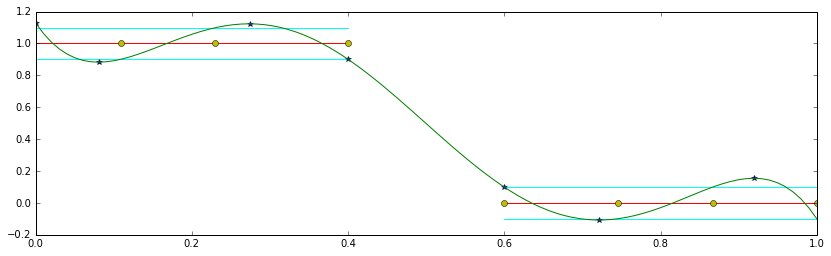

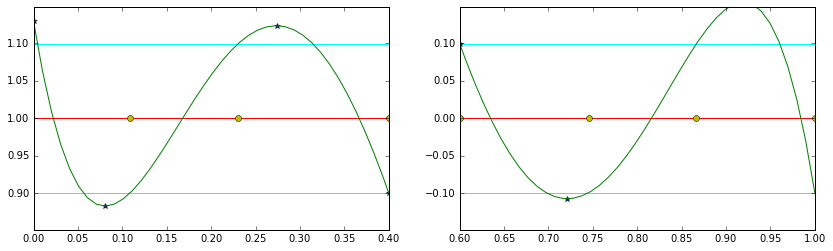

In [62]:
v = interactive(remez_fit_show, A=(0.0, 0.5, 0.4), B=(0.5, 1.0), order=(3,12), iterations=(1, 10))
display(v)